In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d, interp2d

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from ipywidgets import interact, IntSlider

# Preparation

In [2]:
from read_results import read_varnames
import strato_code.kpp4py as kpp

nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


In [3]:
df_range = (
    pd.read_csv('strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.tail(10)

,min,max,mid
OH,3.791087e+01,1.655987e+07,8.279952e+06
Cl,7.667911e-01,7.642127e+05,3.821067e+05
ClO,2.236826e+07,8.342272e+07,5.289549e+07
O3,4.342945e+11,5.292275e+11,4.817610e+11
NO,1.000000e-08,8.828713e+08,4.414357e+08
BrO,1.096853e+04,9.603792e+05,4.856739e+05
O,1.000000e-08,6.590324e+08,3.295162e+08
HO2,9.779919e+02,1.166693e+07,5.833955e+06
NO2,2.134505e+08,1.066423e+09,6.399367e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01


## 0-th order

In [4]:
x0 = df_range['mid'].values
f0 = y0 = kpp.onestep(x0.T).T
x0.shape, y0.shape

((35,), (1, 34))

## 1-st orer

In [5]:
@interact(n=IntSlider(min=0,max=34,step=1,value=29,continuous_update=False))
def plot_1d(n):
    res = 20 # resolution

    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values

    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y = kpp.onestep(x_list.T).T
    plt.plot(x_list[:,n], y/y0-1)
    plt.ylim(-1,1)
    plt.show()

In [6]:
def hdmr_axis(n, res = 10):
    '''Sample along one axis'''
    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y1 = kpp.onestep(x_list.T).T - y0
    return y1, x_list[:,n]

In [7]:
# construct all 1-st order components
y1_list = [None]*(nvar+1)
x1_list = [None]*(nvar+1)

for n in range(nvar+1):
    y1_list[n], x1_list[n] = hdmr_axis(n)

## Interpolate

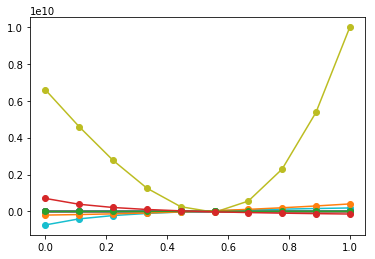

In [8]:
j_in = 34
plt.plot(x1_list[j_in], y1_list[j_in], '-o');

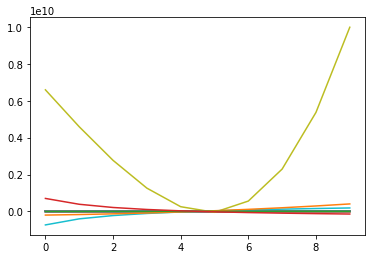

In [9]:
f = interp1d(x1_list[j_in], y1_list[j_in].T)
plt.plot(f(x1_list[j_in]).T);

In [10]:
# interpolate all HDMR components
f1 = []
for j_in in range(nvar+1):
    f1.append( interp1d(x1_list[j_in], y1_list[j_in].T) )

In [11]:
j_in = 6
f1[j_in](df_range['mid'][j_in])/f0

array([[  1.28243260e-09,   8.06274615e-09,  -3.40689483e-09,
          2.24203958e-09,  -4.67368533e-07,  -4.95419427e-07,
          6.72703615e-07,   1.77915000e-07,   9.41755087e-10,
          6.24831815e-10,   9.05656287e-11,  -9.15587090e-12,
          8.91324828e-08,   1.03174034e-09,  -2.56741623e-09,
          2.39054307e-10,  -1.80423124e-10,  -7.92308084e-09,
         -1.13834275e-09,   9.75782990e-10,   5.73019302e-10,
         -7.04540941e-11,   1.15822963e-09,   7.55289678e-10,
         -3.56151804e-07,   9.83098522e-10,   2.36814236e-09,
          1.66402222e-09,   9.05679331e-11,   1.19454491e-09,
         -2.77567527e-07,   5.34853397e-11,   7.62867350e-11,
         -2.29093242e-09]])

In [12]:
j_in = 6
f1[j_in](np.linspace(df_range['max'][j_in], df_range['max'][j_in], 10)).shape

(34, 10)

In [13]:
def eval_hdmr1(x, f0=f0, f1=f1):
    '''Evaluate 1-st order HDMR at x'''
    S = 0.0 # to hold the sum of all components
    
    # 1-st order components
    for j_in in range(nvar+1):
        S += f1[j_in](x[:,j_in]).T
    
    # 0-th order term
    S += f0
    return S

## Test set

In [14]:
df_range['span'] = df_range['max'] - df_range['min']

In [15]:
#x_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, nvar+1))

x_test = np.random.uniform(df_range['min'] + 0.0*df_range['span'],
                           df_range['max'] - 0.0*df_range['span'], 
                           size=(5000, nvar+1))

x_test.shape

(5000, 35)

In [16]:
%time y_test_pred = eval_hdmr1(x_test)
y_test_pred.shape

CPU times: user 72.3 ms, sys: 11 ms, total: 83.3 ms
Wall time: 65.7 ms


(5000, 34)

In [17]:
%time y_test_true = kpp.onestep(x_test.T).T
y_test_true.shape

CPU times: user 1.31 s, sys: 11 ms, total: 1.32 s
Wall time: 1.32 s


(5000, 34)

In [18]:
r2_score(y_test_pred, y_test_true)

0.8613447697361688

In [19]:
r2_score(y_test_pred/df_range['max'][:-1].values, 
         y_test_true/df_range['max'][:-1].values)

0.86134476973616891

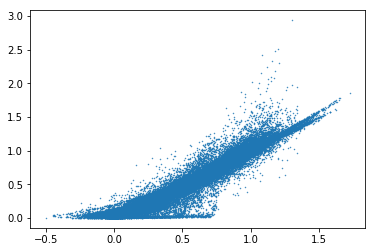

In [20]:
plt.scatter(y_test_pred/df_range['max'][:-1].values, 
            y_test_true/df_range['max'][:-1].values,
            s=0.2)

# Second-order components

In [21]:
@interact(n=IntSlider(min=0,max=34,step=1,value=21,continuous_update=False),
          m=IntSlider(min=0,max=34,step=1,value=27,continuous_update=False),
          k=IntSlider(min=0,max=33,step=1,value=33,continuous_update=False))
def plot_2d(n, m, k):
    res = 20 # resolution

    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

    x_list = np.empty([res, res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,:,n] = range_n.reshape(1,res)
    x_list[:,:,m] = range_m.reshape(res,1)

    y = kpp.onestep(x_list.reshape(res*res,-1).T).T
    
    plt.pcolormesh(range_n, range_m, y.reshape(res,res,-1)[...,k])
    plt.xlabel(df_range.iloc[n].name)
    plt.ylabel(df_range.iloc[m].name)
    plt.title(df_range.iloc[k].name)
    plt.show()

In [22]:
def hdmr_plane(n, m, res = 10):
    '''Sample along one 2D plane'''

    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

    x_list = np.empty([res, res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,:,n] = range_n.reshape(1,res)
    x_list[:,:,m] = range_m.reshape(res,1)

    y = kpp.onestep(x_list.reshape(res*res,-1).T).T.reshape(res,res,-1)
    
    # Use 1D axis to approximate 2D plane
    y_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
    
    y2 = y - y_approx # store the differene in 2-nd order components

    return y2

In [23]:
%%time
# construct all 2-nd order components
y2_list = np.empty([nvar+1, nvar+1], dtype=object)
x2_list = np.empty([nvar+1, nvar+1], dtype=object)

for n in range(nvar+1):
    print(n, end=' ')
    for m in range(nvar+1):
        if m==n:
            break
        y2_list[n,m] = hdmr_plane(n, m)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 CPU times: user 15 s, sys: 239 ms, total: 15.2 s
Wall time: 15.7 s


## Difference between 1D approximation and true 2D plane

In [24]:
@interact(n=IntSlider(min=0,max=34,step=1,value=33,continuous_update=False),
          m=IntSlider(min=0,max=34,step=1,value=29,continuous_update=False),
          k=IntSlider(min=0,max=33,step=1,value=20,continuous_update=False))
def plot_2d_diff(n, m, k):
    
    if n < m:
        m, n = n, m
    if n == m:
        print('no 2D component for n=m')
        return
    
    res = 10 # determined by data
    
    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)
    
    # Use 1D axis to approximate 2D plane
    y2_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
    
    ratio = y2_list[n,m][...,k]/y2_approx[...,k]
    ratio_range = np.max(np.abs(ratio))
    
    plt.pcolormesh(range_n, range_m, ratio,
                   cmap='bwr', vmin=-ratio_range, vmax=ratio_range)
    
    plt.xlabel(df_range.iloc[n].name)
    plt.ylabel(df_range.iloc[m].name)
    plt.title(df_range.iloc[k].name)
    
    plt.colorbar()
    plt.show()

Strong correlation between SUN (last variable) and other variables.

In [25]:
ratio_list = np.empty([nvar+1, nvar+1], dtype=object)

res = 10
for n in range(nvar+1):
    for m in range(nvar+1):
        if n <= m:
            break
        y2_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
        ratio_list[n,m] = y2_list[n,m]/y2_approx

In [26]:
for n in range(nvar+1):
    for m in range(nvar+1):
        if n <= m:
            break
        #max_temp = np.max(np.mean(np.abs(ratio_list[n,m]), axis=2))
        max_temp = np.max(np.max(np.abs(ratio_list[n,m]), axis=2))
        if max_temp > 0.1:
            print(n, m, max_temp)

21 17 0.331095016063
27 6 0.112238959713
27 7 0.141664318166
27 17 0.139707936641
27 21 849.373160491
28 21 0.66110787723
29 7 0.135333525922
29 21 9.87806255738
29 27 0.353542082494
30 27 0.346435160737
30 29 0.207294821365
33 7 0.127779299102
33 11 0.122933197142
33 21 6.90904172205
33 27 0.335150164119
33 29 0.799783108799
33 30 0.197819781203
34 0 25.481695494
34 1 3.16916197085
34 2 22.2864407016
34 3 34.4010160575
34 4 28.3936159993
34 5 2.29197316675
34 6 235.941808703
34 7 46.0928413124
34 8 2.47406301186
34 9 2.95984613602
34 10 3.14762043439
34 11 26.0151714399
34 12 30.5423137142
34 13 15.667848493
34 14 3.01790323876
34 15 69.6729754342
34 16 18.2519861624
34 17 6.75169629243
34 18 3.11743656512
34 19 2.30495095214
34 20 24.7975008043
34 21 2976.01165799
34 22 37.8305090871
34 23 41.4568672012
34 24 10.1710059423
34 25 17.1403067738
34 26 9.26247013069
34 27 74.027259101
34 28 12.7303454444
34 29 733.662218254
34 30 19.9583778353
34 31 27.4070611366
34 32 13.8666725639
34 3

## Interpolation

In [27]:
res = 10
n = 34 # SUN
range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)

# interpolate all HDMR components
f2_SUN = np.empty([nvar, nvar], dtype=object) # [input except SUN, output]

for m in range(nvar): # input except SUN
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)
    
    for k in range(nvar): # output variable
        # interp2d can only fit one level at a time
        f2_SUN[m,k] = interp2d(range_n, range_m, y2_list[n,m][...,k])

In [28]:
def eval_hdmr2_sun(x, f2_SUN=f2_SUN):
    '''
    Evaluate 2-nd order HDMR at x
    Only consider correlation with SUN. Skip other correlations
    '''
    S = eval_hdmr1(x)  # start with 1-st order approx
    
    for i, xi in enumerate(x): # data points
        for k in range(nvar): # output variable
            for m in range(nvar):
                S[i, k] += f2_SUN[m, k](xi[-1], xi[m])

    return S

## Test set

In [29]:
x_test.shape

(5000, 35)

In [30]:
%time y_test_pred_2nd = eval_hdmr2_sun(x_test[:200])
y_test_pred_2nd.shape

CPU times: user 5.74 s, sys: 38.5 ms, total: 5.78 s
Wall time: 5.8 s


(200, 34)

In [31]:
r2_score(y_test_pred_2nd[:200], y_test_true[:200])

0.93144723321754741

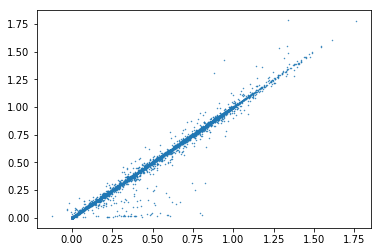

In [32]:
plt.scatter(y_test_pred_2nd/df_range['max'][:-1].values, 
            y_test_true[:200]/df_range['max'][:-1].values,
            s=0.2)

## Add more 2nd-order components

In [33]:
res = 10
n_list = [27, 29, 33] # species with significant correlation with others

f2_more = np.empty(len(n_list), dtype=object)

for ni, n in enumerate(n_list):
    f2_more[ni] = np.empty([n, nvar], dtype=object)
    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)

    for m in range(n): # from 0 to n
        range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

        for k in range(nvar): # output variable
            f2_more[ni][m,k] = interp2d(range_n, range_m, y2_list[n,m][...,k])

In [34]:
def eval_hdmr2_more(x, f2_more=f2_more):
    '''
    Add more 2nd-order components
    '''
    S = eval_hdmr2_sun(x)  # start with previous 2nd-order approx
    
    for i, xi in enumerate(x): # data points
        for ni, n in enumerate(n_list):
            for m in range(n):
                for k in range(nvar): # output variable
                     # remember to use n for input, not -1 anymore
                    S[i, k] += f2_more[ni][m,k](xi[n], xi[m])

    return S

### Debug

In [35]:
xi = df_range['mid'].values.copy().reshape(1,-1)
xi[:,-1] = 0.2
xi[:,33] = df_range['min'].iloc[33]
xi[:,29] = df_range['max'].iloc[29]

In [36]:
yi_true = kpp.onestep(xi.T).T
yi_true.shape

(1, 34)

In [37]:
eval_hdmr1(xi)/yi_true

array([[ 1.00290836,  1.0008962 ,  1.01106342,  0.99926151,  1.02353459,
         1.02499017,  1.01622998,  1.03351743,  0.99403565,  0.99580098,
         1.04526468,  0.9984915 ,  1.00085429,  1.03645005,  0.99948014,
         1.00002303,  1.00396727,  1.00931033,  1.00367441,  1.01887461,
         1.48141834,  0.99969033,  1.0621583 ,  0.99487657,  0.99738783,
         0.99273513,  0.99926979,  0.99631358,  1.00014984,  0.99578581,
         0.98229262,  1.0104797 ,  1.01697129,  1.00328907]])

In [38]:
eval_hdmr2_sun(xi)/yi_true

array([[ 0.99714426,  1.01581302,  1.01442851,  0.98841217,  1.02273569,
         1.02484278,  1.01702912,  1.03148875,  0.99416661,  0.99654729,
         1.0488581 ,  0.99834116,  1.00111   ,  1.01302787,  0.98265192,
         1.00001213,  1.00279541,  1.00850433,  1.00305402,  1.05956269,
         1.18313986,  0.99818608,  1.03397341,  0.99834792,  0.99487215,
         0.99116607,  0.98841468,  0.9974663 ,  1.00003172,  0.98947597,
         0.98223734,  1.01202222,  1.01594635,  1.00840547]])

In [39]:
eval_hdmr2_more(xi)/yi_true

array([[ 1.00806677,  1.0087094 ,  1.01653458,  0.99407817,  1.02498967,
         1.02713692,  1.01147425,  1.03533379,  1.00876024,  1.01505139,
         1.04873445,  0.99834519,  1.00093187,  0.97885817,  0.99374925,
         0.99994613,  1.00019247,  1.00447365,  0.99917212,  1.13174245,
         0.69447131,  0.99872062,  1.03890631,  1.00387657,  0.99864607,
         1.01406686,  0.9940807 ,  0.99903328,  1.00001193,  0.98702959,
         0.98545553,  1.01200855,  0.9965982 ,  1.01049169]])

### Test 

In [40]:
%time y_test_pred_2nd_more = eval_hdmr2_more(x_test[:200])
y_test_pred_2nd_more.shape

CPU times: user 21.2 s, sys: 161 ms, total: 21.3 s
Wall time: 21.5 s


(200, 34)

In [41]:
r2_score(y_test_pred_2nd_more, y_test_true[:200])

0.93606241183404015

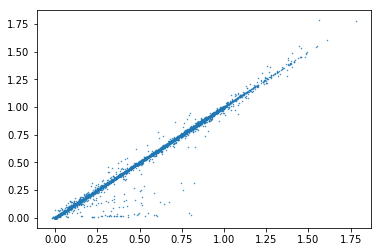

In [42]:
plt.scatter(y_test_pred_2nd_more/df_range['max'][:-1].values, 
            y_test_true[:200]/df_range['max'][:-1].values,
            s=0.2)

Only help very little